<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/supplementary/Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning

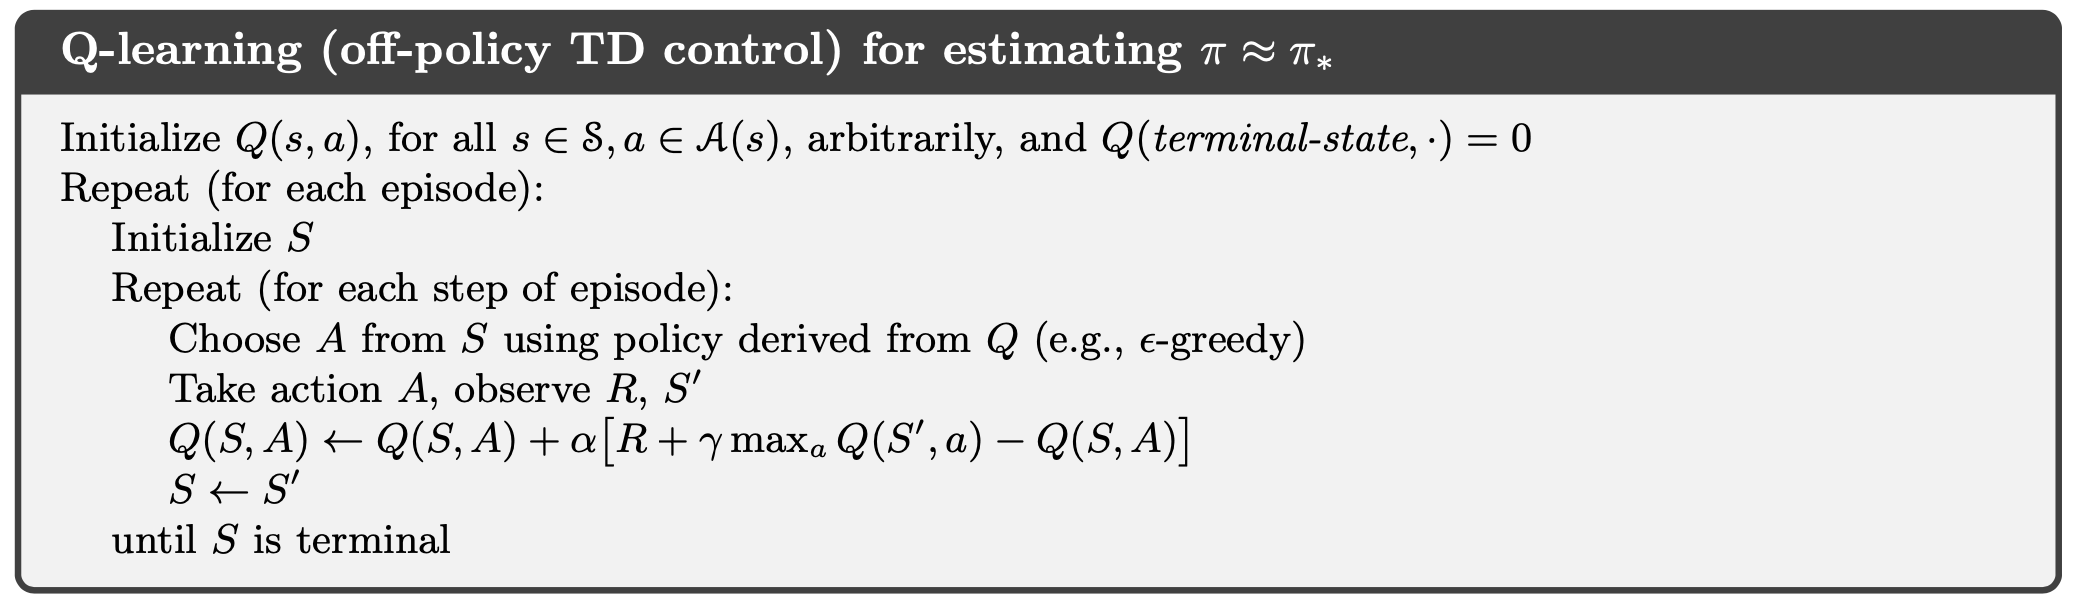

이번 노트북에서는 Q-learning을 구현해보도록 하겠습니다.

구현에 필요한 라이브러리들을 import 합니다. 배열 출력시 보기 편하도록 세팅해줍니다.

In [1]:
import random
import gym
import numpy as np

from gym import spaces
np.set_printoptions(precision=3, suppress=True)

# Environment

이번 Q-learning에서 사용할 환경은 GridWorld 환경입니다. 다음과 같이 (3, 5) 모양의 환경이며 절벽을 피해(state 11, state 12, state 13) 왼쪽 아래(state 10)에서 시작하여 오른쪽 아래(state 14)로 이동하는 것이 목표인 환경입니다. 

Action으로는 위(0), 아래(1), 왼쪽(2), 오른쪽(3)이 있습니다.

절벽으로 이동시에는 -100의 reward를 받게되며 goal state로 이동시에는 +100의 reward를 받게됩니다. 나머지 이동은 모두 -1의 reward를 받게됩니다.

절벽으로 떨어지거나 goal state로 이동하면 한 에피소드가 끝나게 됩니다.

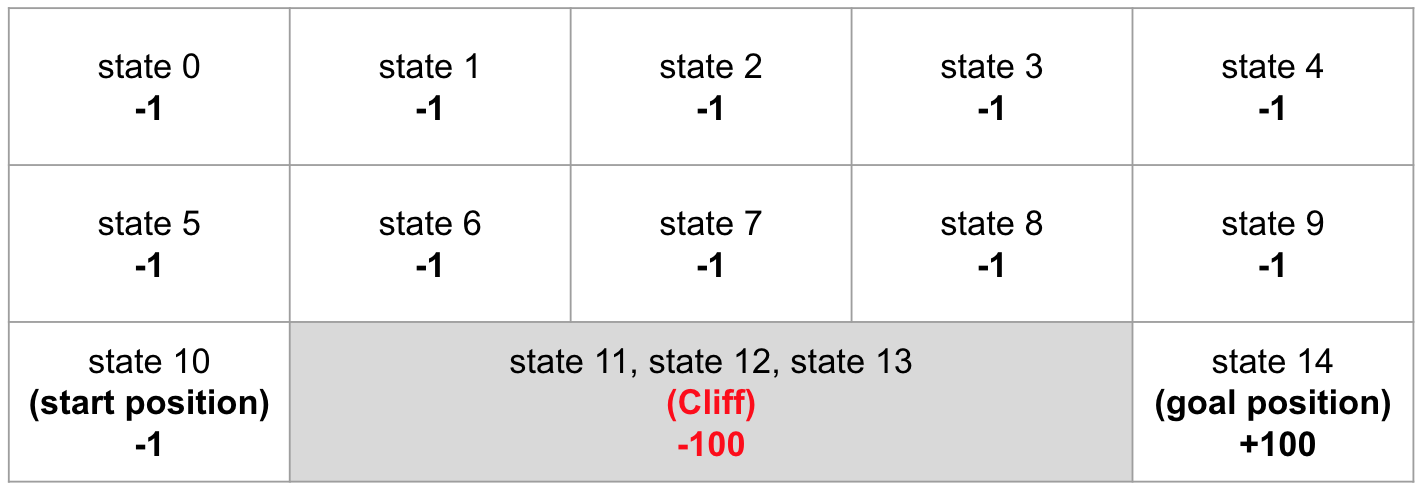

구현을 위해 환경을 정의해줍니다. 환경은 gym 프레임워크 구조를 따라서 구현하도록 합니다.

In [2]:
class CliffEnv(gym.Env):
    def __init__(self):
        self.episode_map = np.zeros((3, 5))
        self.start_pos = [2, 0]
        self.goal_pos = [2, 4]
        self.action_space = spaces.Discrete(4) # (위, 아래, 왼쪽, 오른쪽) 4가지 action
        self.state_space = spaces.Discrete(15) # 3 * 5 = 15가지 state

    def step(self, action):
        if action == 0:
            self.cur_pos[0] -= 1
        elif action == 1:
            self.cur_pos[0] += 1
        elif action == 2:
            self.cur_pos[1] -= 1
        elif action == 3:
            self.cur_pos[1] += 1
        else:
            raise Exception("the action is not defined")

        self.cur_pos[0] = max(0, self.cur_pos[0])
        self.cur_pos[0] = min(self.cur_pos[0], self.episode_map.shape[0] - 1)

        self.cur_pos[1] = max(0, self.cur_pos[1])
        self.cur_pos[1] = min(self.cur_pos[1], self.episode_map.shape[1] - 1)
    
        info = {}

        return self._get_state(), self._get_reward(), self._is_done(), info

    def reset(self):
        self.episode_map[self.goal_pos[0], self.goal_pos[1]] = 2
        self.episode_map[2, 1] = -1
        self.episode_map[2, 2] = -1
        self.episode_map[2, 3] = -1

        self.cur_pos = [self.start_pos[0], self.start_pos[1]]

        return self._get_state()

    def render(self):
        self.episode_map[self.cur_pos[0], self.cur_pos[1]] = 1
        print(self.episode_map)
        self.episode_map[self.cur_pos[0], self.cur_pos[1]] = 0

    def _get_state(self):
        return self.cur_pos[0]*self.episode_map.shape[1] + self.cur_pos[1]
    
    def _get_reward(self):
        if self.cur_pos == [2, 1] or self.cur_pos == [2, 2] or self.cur_pos == [2, 3]:
            return -100
        if self.cur_pos == [self.goal_pos[0], self.goal_pos[1]]:
            return 100
        return -1
    
    def _is_done(self):
        # Cliff
        if self.cur_pos == [2, 1] or self.cur_pos == [2, 2] or self.cur_pos == [2, 3]:
            return True
        # Get to the goal
        if self.cur_pos == self.goal_pos:
            return True
        # 나머지
        else:
            return False

In [3]:
action_to_str = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}

# Render

환경 구현이 끝난 후 제대로 구현되었는지 render 함수를 통해 확인합니다. 배열이 현재 map을 나타내며, 1은 현재 agent의 위치, -1은 절벽, 2는 goal을 나타냅니다. 나머지는 0으로 표시합니다.

현재 state와 정해준 action, reward, epiosde 종료 여부 등을 확인할 수 있습니다.

In [4]:
env = CliffEnv()
state = env.reset()
for _ in range(20):
    print()
    print("=" * 60)
    action = env.action_space.sample()
    action_str = action_to_str[action]
    env.render()
    next_state, reward, done, _ = env.step(action) # take a random action
    print("On the state {}, an agent takes action {}, gets reward {},\nnext_state {}, episode done {}".format(state, action_str, reward, next_state, done))
    print("=" * 60)
    print()

    state = next_state
    
    if done:
        state = env.reset()


[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1. -1. -1. -1.  2.]]
On the state 10, an agent takes action UP, gets reward -1,
next_state 5, episode done False


[[ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0. -1. -1. -1.  2.]]
On the state 5, an agent takes action LEFT, gets reward -1,
next_state 5, episode done False


[[ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0. -1. -1. -1.  2.]]
On the state 5, an agent takes action DOWN, gets reward -1,
next_state 10, episode done False


[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1. -1. -1. -1.  2.]]
On the state 10, an agent takes action UP, gets reward -1,
next_state 5, episode done False


[[ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0. -1. -1. -1.  2.]]
On the state 5, an agent takes action RIGHT, gets reward -1,
next_state 6, episode done False


[[ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0. -1. -1. -1.  2.]]
On the state 6, an agent takes action UP, gets reward -1,
next_state 1, episode done False


[[ 0.  1.  

# Q-Table

Q-learning에서 현재 state에서 선택할 수 있는 action에 따른 q 값을 저장하고 있는 Q-table을 출력하는 함수입니다. 아래의 그림과 같은 Q-table을 배열 형태로 출력합니다.

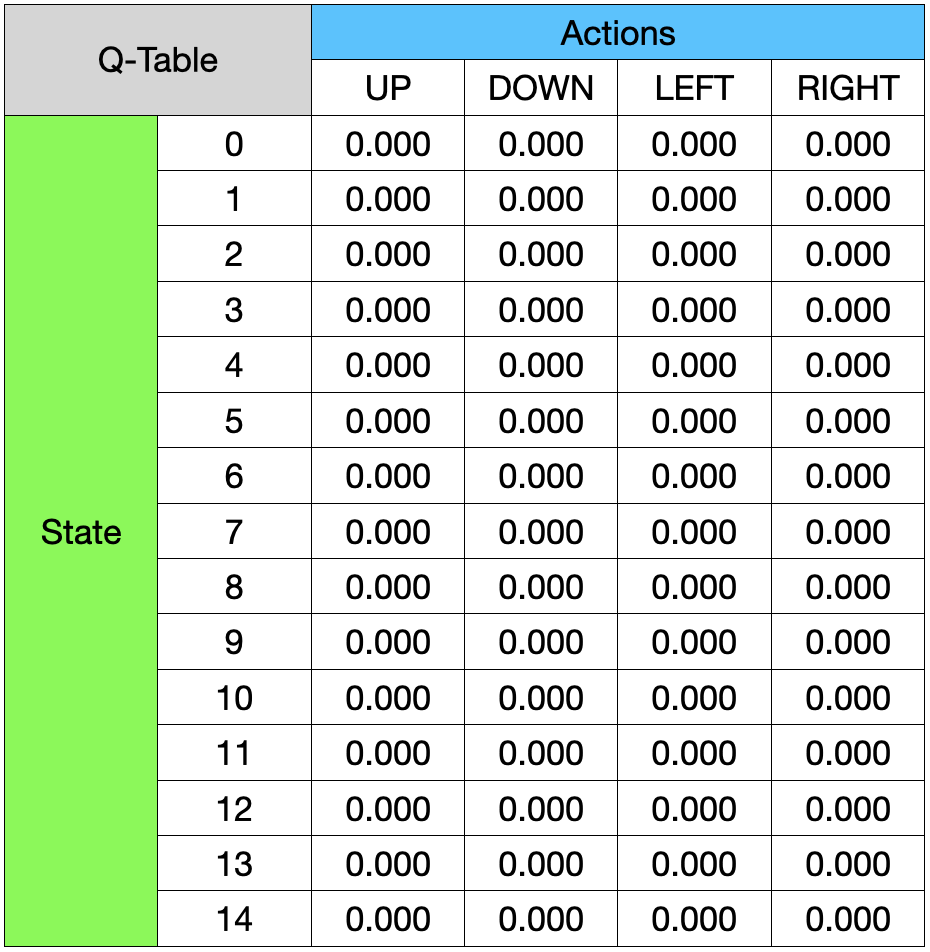

In [5]:
def print_q_table(q_table, t):
    print()
    print("=" * 70)
    print("episode", t)
    print("    UP      DOWN    LEFT    RIGHT")
    print(q_table)
    print("=" * 70)
    print()

# Main

학습에 필요한 환경과 Q-table, 하이퍼파라미터 등을 정의하는 부분입니다.

In [6]:
env = CliffEnv()
q_table = np.zeros((15, 4)) # [number of state, number of actions]

total_episode = 1000
epsilon = 0.1
learning_rate = 0.01
gamma = 0.99

총 total_episode만큼의 에피소드를 돌면서 Q-table을 업데이트합니다. 매 50 에피소드마다 Q-table을 출력하여 적절하게 업데이트 되고 있는지 확인합니다.

시간이 지남에 따라 학습을 하게되며 업데이트된 Q-table이 모든 state에서 모든 action에 대한 Q-value를 잘 학습하고 있는 것을 확인할 수 있습니다.

In [7]:
for t in range(total_episode): # for each episode

    if t % 50 == 0:
        print_q_table(q_table, t)

    state = env.reset()
    done = False

    while not done: # for each step of episode
        # Choose A from S using policy derived from Q (here, we use e-greedy)
        if random.random() > epsilon:
            action = q_table[state].argmax()
        else:
            action = env.action_space.sample()

        # env.render()

        # Take action A, observe R, S'
        next_state, reward, done, _ = env.step(action)

        # Update Q table
        # Q(S, A) <- Q(S, A) + alpha[R + gamma*max_aQ(S', a) - Q(S, A)]
        temporal_difference = reward + gamma*q_table[next_state].max() - q_table[state, action]
        q_table[state, action] = q_table[state, action] + learning_rate * temporal_difference

        # S <- S'
        state = next_state


episode 0
    UP      DOWN    LEFT    RIGHT
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


episode 50
    UP      DOWN    LEFT    RIGHT
[[-0.399 -0.398 -0.399 -0.405]
 [-0.29  -0.292 -0.283 -0.289]
 [-0.14  -0.143 -0.148 -0.143]
 [-0.04   0.06  -0.041 -0.047]
 [-0.02   0.26  -0.01  -0.01 ]
 [-0.509 -0.506 -0.508 -0.503]
 [-0.297 -1.    -0.317 -0.3  ]
 [-0.09  -1.99  -0.106  0.261]
 [-0.03  -1.    -0.031  5.377]
 [-0.02  32.427  0.001  0.   ]
 [-0.757 -0.757 -0.757 -6.793]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]


episode 100
    UP      DOWN    LEFT    RIGHT
[[ -0.548  -0.556  -0.548  -0.549]
 [ -0.359  -0.357  -0.363  -0.355]
 [ -0.16   -0.103  -0.171  -0.151]
 [ -0.04    0.102  -0.041  -0.047]
 [ -0.02    0.758  -0.01   -